In [2]:
import torch
print(torch.__version__)

2.4.1+cu121


In [3]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


c:\users\yoonseok\documents\coding\gencycle\python\point_e\models\download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


<All keys matched successfully>

In [6]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [14]:
# Set a prompt to condition on.
prompt = 'a white headset'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

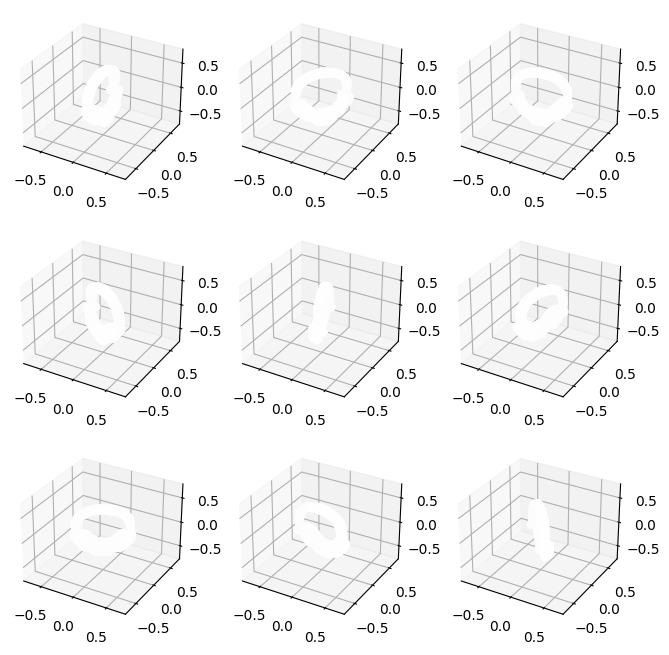

In [15]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))


In [16]:
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.plotting import plot_point_cloud
from point_e.util.point_cloud import PointCloud

In [17]:
print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [18]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
# Write the mesh to a PLY file to import into some other program.
with open('mesh.ply', 'wb') as f:
    mesh.write_ply(f)

In [22]:
import open3d as o3d
import numpy as np

# PLY 파일 읽기 (메쉬 데이터로 불러오기)
ply_file = "mesh.ply"
mesh = o3d.io.read_triangle_mesh(ply_file)

# 법선 계산 (옵션)
mesh.compute_vertex_normals()

# 메쉬 시각화
o3d.visualization.draw_geometries([mesh])

# 메쉬 정보 확인
print("Vertices:")
print(np.asarray(mesh.vertices))  # 정점 데이터
print("Triangles:")
print(np.asarray(mesh.triangles))  # 삼각형 데이터

Vertices:
[[-0.05282521 -0.37838709 -0.08225805]
 [-0.04935482 -0.37838709 -0.08608434]
 [-0.04935482 -0.38088459 -0.08225805]
 ...
 [ 0.09010613  0.213871   -0.18096772]
 [ 0.09092134  0.213871   -0.14806449]
 [ 0.0888412   0.213871   -0.11516127]]
Triangles:
[[  1   2   0]
 [  3   0   2]
 [  1   0   4]
 ...
 [698 637 638]
 [698 638 699]
 [699 638 628]]


In [21]:
import open3d as o3d

# PLY 파일 읽기
ply_file = "mesh.ply"
mesh = o3d.io.read_triangle_mesh(ply_file)

# 메쉬 데이터 확인 (옵션)
print("Vertices:")
print(np.asarray(mesh.vertices))
print("Triangles:")
print(np.asarray(mesh.triangles))

# OBJ 파일로 저장
obj_file = "mesh.obj"
o3d.io.write_triangle_mesh(obj_file, mesh)
print(f"Mesh saved as {obj_file}")


Vertices:
[[-0.05282521 -0.37838709 -0.08225805]
 [-0.04935482 -0.37838709 -0.08608434]
 [-0.04935482 -0.38088459 -0.08225805]
 ...
 [ 0.09010613  0.213871   -0.18096772]
 [ 0.09092134  0.213871   -0.14806449]
 [ 0.0888412   0.213871   -0.11516127]]
Triangles:
[[  1   2   0]
 [  3   0   2]
 [  1   0   4]
 ...
 [698 637 638]
 [698 638 699]
 [699 638 628]]
Mesh saved as mesh.obj
